In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('DTdata_banknote_authentication.csv')

In [4]:
data.head()

,3.6216,8.6661,-2.8073,-0.44699,0
0,4.54590,8.1674,-2.4586,-1.46210,0
1,3.86600,-2.6383,1.9242,0.10645,0
2,3.45660,9.5228,-4.0112,-3.59440,0
3,0.32924,-4.4552,4.5718,-0.98880,0
4,4.36840,9.6718,-3.9606,-3.16250,0


In [5]:
data.shape

(1371, 5)

In [6]:
data.isnull().values.sum()

0

In [7]:
data.isnull().sum()

3.6216      0
8.6661      0
-2.8073     0
-0.44699    0
0           0
dtype: int64

In [8]:
data.isnull().any().any()

False

In [9]:
data.dtypes

3.6216      float64
8.6661      float64
-2.8073     float64
-0.44699    float64
0             int64
dtype: object

In [10]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain= info_gain
        self.value = value

In [11]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
        

In [12]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [13]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_0 <= 0.26877 ? 0.2622028665401259
 left:X_1 <= 7.5032 ? 0.13531109768091729
  left:X_0 <= -0.40804 ? 0.015882012166573423
    left:X_2 <= 6.2169 ? 0.006020023164857641
        left:1.0
        right:1.0
    right:X_2 <= 2.135 ? 0.1971049839068061
        left:1.0
        right:0.0
  right:X_0 <= -5.1661 ? 0.30055401662049874
    left:1.0
    right:0.0
 right:X_2 <= -4.4738 ? 0.03993645757594755
  left:X_0 <= 2.2279 ? 0.40816326530612246
    left:1.0
    right:0.0
  right:X_0 <= 1.581 ? 0.016750952439149147
    left:X_2 <= -2.3 ? 0.11506199737272113
        left:1.0
        right:0.0
    right:X_0 <= 2.031 ? 0.0008196897955161445
        left:0.0
        right:0.0


In [14]:

Y_pred = classifier.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9527272727272728

In [15]:
# df

x = df.iloc[:,-1]
np.shape(x)

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
dt = DecisionTreeClassifier(random_state=42)

In [19]:
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [22]:
print(dt.score(X_train, Y_train))
print(dt.score(X_test, Y_test))

1.0
0.9890909090909091


In [23]:
dt = DecisionTreeClassifier(max_depth = 5, min_samples_split= 7, min_samples_leaf=3, random_state=42)

In [24]:
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [25]:
print(dt.score(X_train,Y_train))
print(dt.score(X_test,Y_test))

0.9844890510948905
0.9672727272727273


In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
grid = GridSearchCV(estimator = DecisionTreeClassifier(), 
                   param_grid = {'max_depth':[3,5,7,10],
                                'min_samples_split':[5,10,15,20],
                                'min_samples_leaf':[2,3,4,5,6,7]},
                   cv = 5,
                   verbose=1)

In [28]:
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                  

In [29]:
grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [30]:
grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5}

In [31]:
grid.best_score_

0.9844890510948905

In [32]:
dt = DecisionTreeClassifier(max_depth = 7,
                           min_samples_split=15,
                           min_samples_leaf=6,
                           random_state=42)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [33]:
print(dt.score(X_train, Y_train))
print(dt.score(X_test, Y_test))

0.9927007299270073
0.9818181818181818


In [34]:
preds = dt.predict(X_test)

In [35]:
from sklearn.metrics import confusion_matrix

In [37]:
confusion_matrix(Y_test, preds)

array([[148,   1],
       [  4, 122]])

In [38]:
import scikitplot as skplt

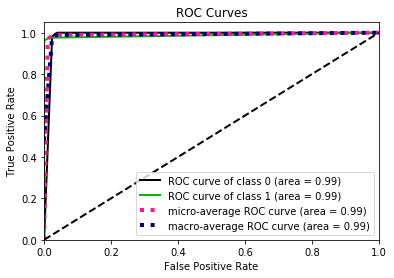

In [40]:
skplt.metrics.plot_roc(Y_test, dt.predict_proba(X_test))

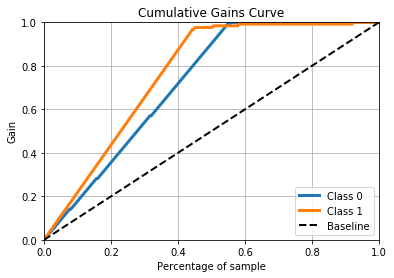

In [41]:
skplt.metrics.plot_cumulative_gain(Y_test, dt.predict_proba(X_test))

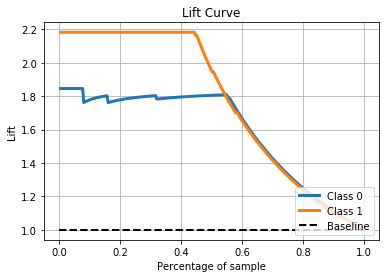

In [42]:
skplt.metrics.plot_lift_curve(Y_test, dt.predict_proba(X_test))